### Experiment 1:

Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:

1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

Dataset link:https://www.kaggle.com/datasets/yasserh/uber-fares-dataset 

In [133]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [134]:
#importing the dataset
df = pd.read_csv("uber.csv")

### 1. Pre-process the dataset.

In [135]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [136]:
df.info() #To get the required information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [137]:
df.columns #TO get number of columns in the dataset

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [138]:
df = df.drop(['Unnamed: 0', 'key'], axis= 1) #To drop unnamed column as it isn't required

In [139]:
df.shape #To get the total (Rows,Columns)

(200000, 7)

In [140]:
df.dtypes #To get the type of each column

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Column pickup_datetime is in wrong format (Object). Convert it to DateTime Format

In [141]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [142]:
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

### Filling Missing values

In [143]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [144]:
df['dropoff_latitude'].fillna(value=df['dropoff_latitude'].mean(),inplace = True)
df['dropoff_longitude'].fillna(value=df['dropoff_longitude'].median(),inplace = True)

In [145]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### To segregate each time of date and time

In [146]:
df= df.assign(hour = df.pickup_datetime.dt.hour,
 day= df.pickup_datetime.dt.day,
 month = df.pickup_datetime.dt.month,
 year = df.pickup_datetime.dt.year,
 dayofweek = df.pickup_datetime.dt.dayofweek)

### Here we are going to use Heversine formula to calculate the distance between two points and journey, using the longitude and latitude values.

Heversine formula hav(θ) = sin**2(θ/2).


In [147]:
from math import *
# function to calculate the travel distance from the longitudes and latitudes
def distance_transform(longitude1, latitude1, longitude2, latitude2):
 travel_dist = []

 for pos in range(len(longitude1)):
    long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
    dist_long = long2 - long1
    dist_lati = lati2 - lati1
    a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
    c = 2 * asin(sqrt(a))*6371
    travel_dist.append(c)

 return travel_dist

In [148]:
df['dist_travel_km'] = distance_transform(df['pickup_longitude'].to_numpy(),
 df['pickup_latitude'].to_numpy(),
 df['dropoff_longitude'].to_numpy(),
 df['dropoff_latitude'].to_numpy()
 )

### Checking outliers and filling them

fare_amount             Axes(0.125,0.786098;0.352273x0.0939024)
pickup_longitude     Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_latitude         Axes(0.125,0.673415;0.352273x0.0939024)
dropoff_longitude    Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_latitude        Axes(0.125,0.560732;0.352273x0.0939024)
passenger_count      Axes(0.547727,0.560732;0.352273x0.0939024)
hour                    Axes(0.125,0.448049;0.352273x0.0939024)
day                  Axes(0.547727,0.448049;0.352273x0.0939024)
month                   Axes(0.125,0.335366;0.352273x0.0939024)
year                 Axes(0.547727,0.335366;0.352273x0.0939024)
dayofweek               Axes(0.125,0.222683;0.352273x0.0939024)
dist_travel_km       Axes(0.547727,0.222683;0.352273x0.0939024)
dtype: object

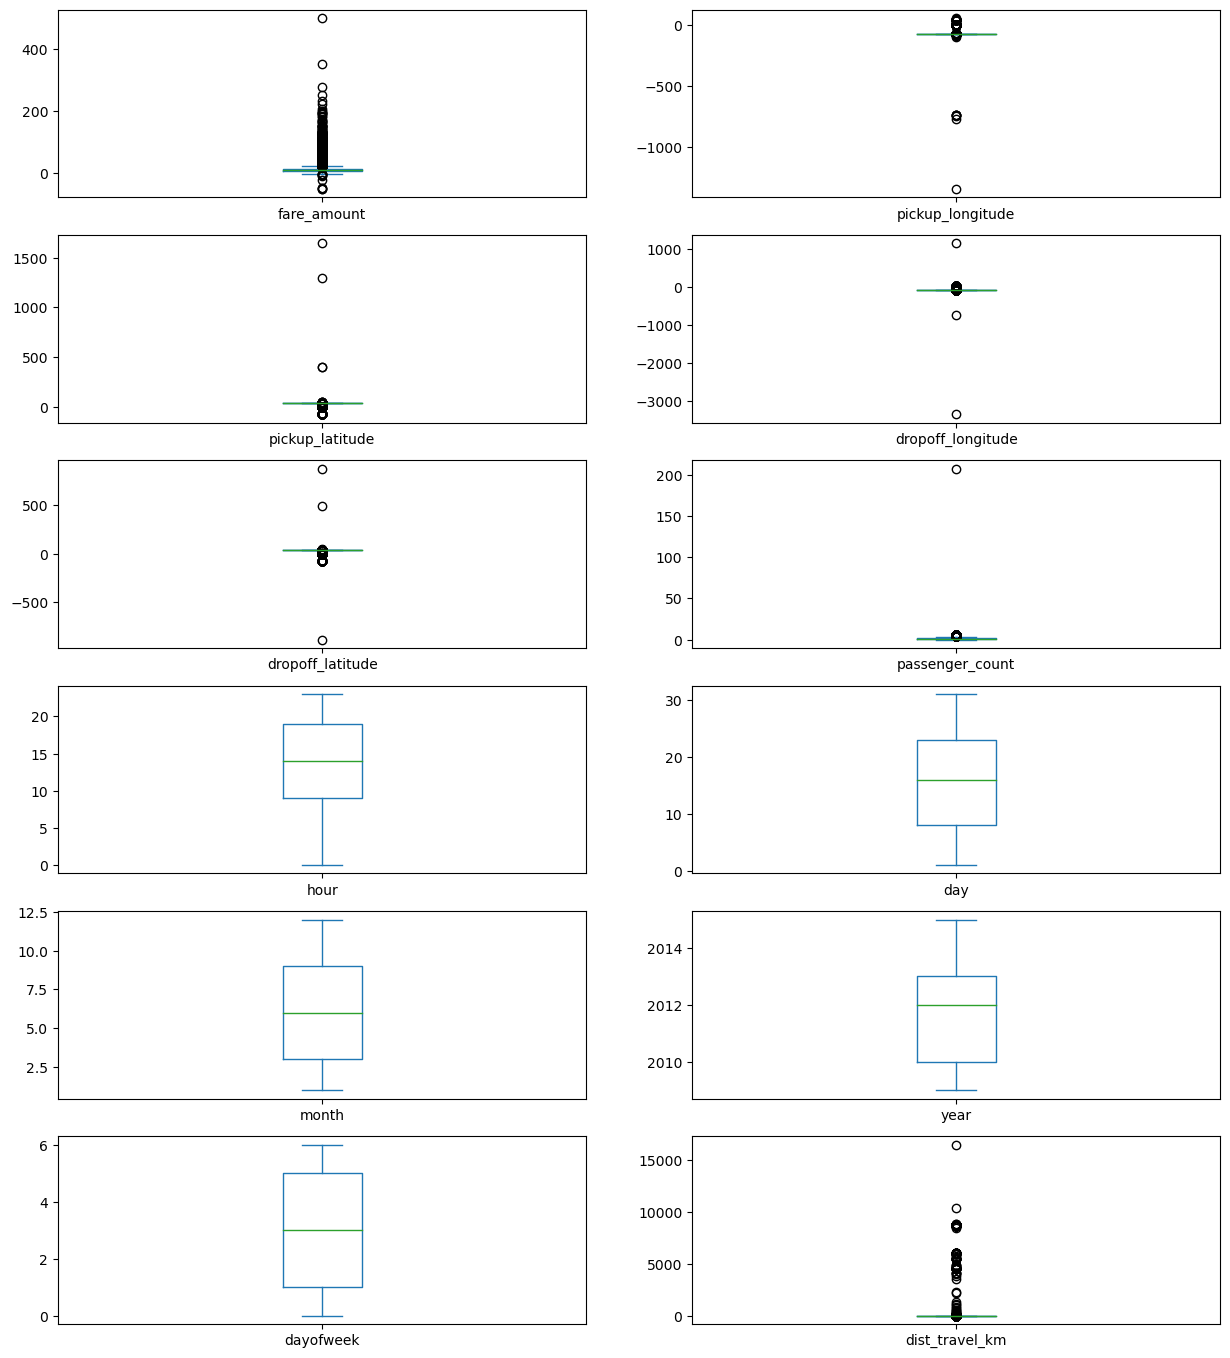

In [149]:
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) #Boxplot to check the outliers

In [150]:
#Using the InterQuartile Range to fill the values
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1
def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
        return df1

fare_amount             Axes(0.125,0.786098;0.352273x0.0939024)
pickup_longitude     Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_latitude         Axes(0.125,0.673415;0.352273x0.0939024)
dropoff_longitude    Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_latitude        Axes(0.125,0.560732;0.352273x0.0939024)
passenger_count      Axes(0.547727,0.560732;0.352273x0.0939024)
hour                    Axes(0.125,0.448049;0.352273x0.0939024)
day                  Axes(0.547727,0.448049;0.352273x0.0939024)
month                   Axes(0.125,0.335366;0.352273x0.0939024)
year                 Axes(0.547727,0.335366;0.352273x0.0939024)
dayofweek               Axes(0.125,0.222683;0.352273x0.0939024)
dist_travel_km       Axes(0.547727,0.222683;0.352273x0.0939024)
dtype: object

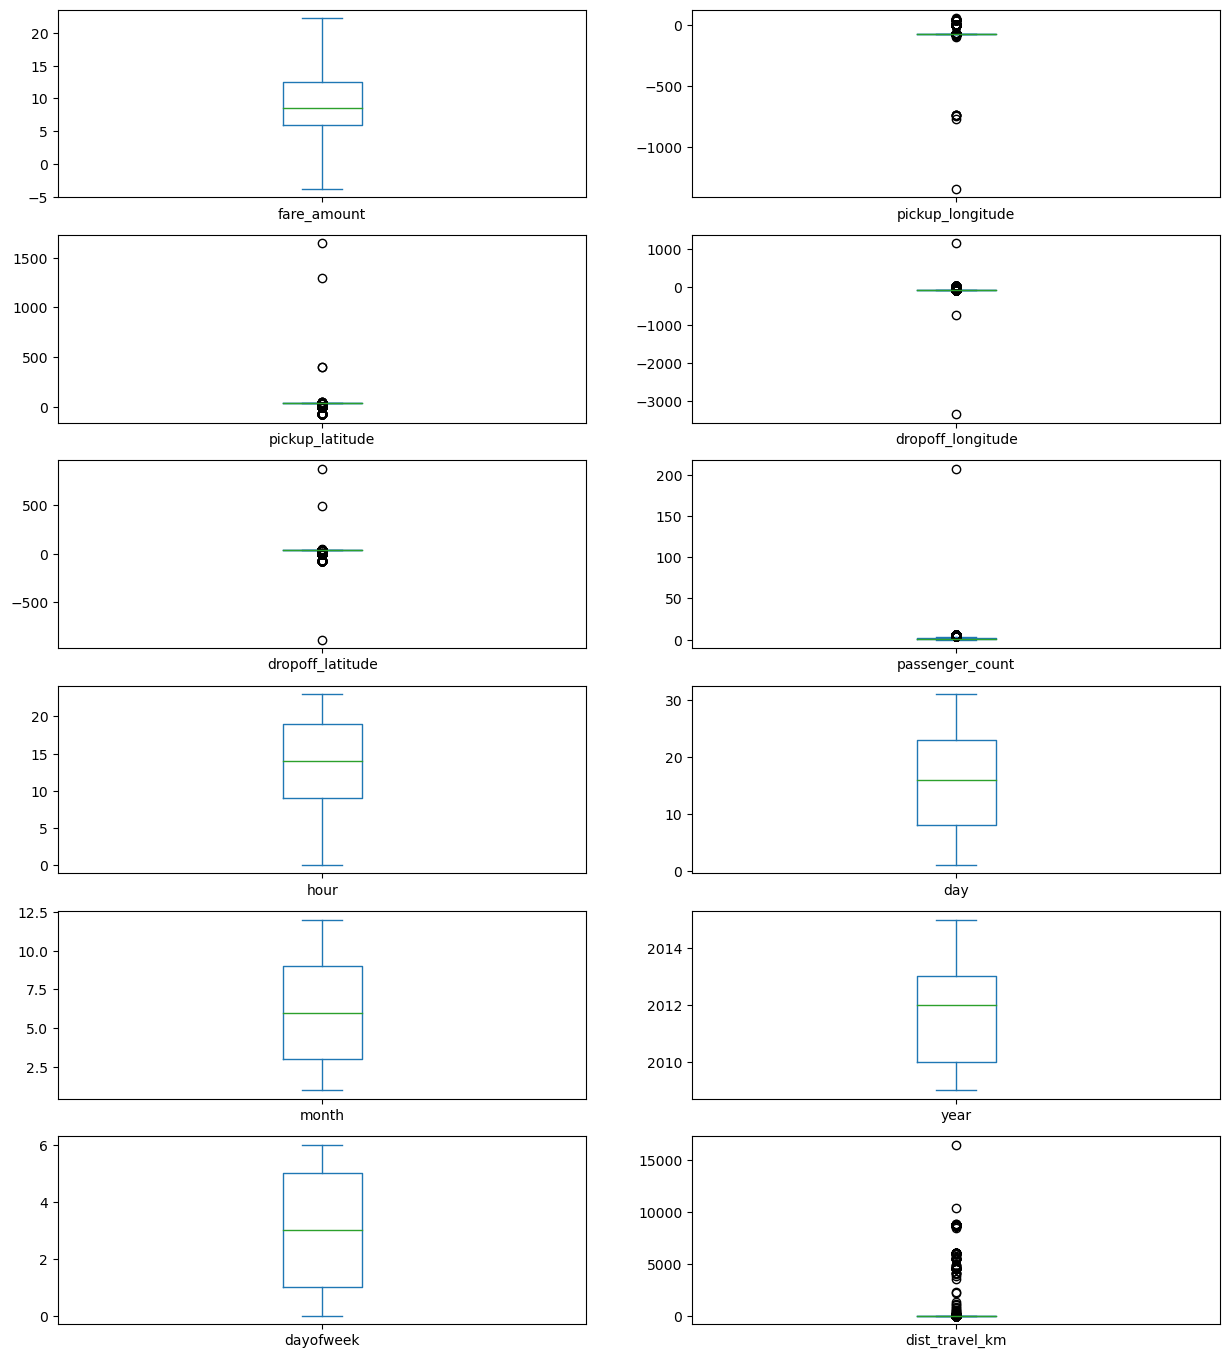

In [151]:
df = treat_outliers_all(df , df.iloc[: , 0::])
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) #Boxplot shows that dataset is free from outliers

In [152]:
#Uber doesn't travel over 130 kms so minimize the distance
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (200000, 13)


In [153]:
#Finding inccorect latitude (Less than or greater than 90) and longitude (greater than or less than 180)
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
 (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
 (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
 (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
 ]

In [154]:
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [155]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
year                 0
dayofweek            0
dist_travel_km       0
dtype: int64

<Axes: >

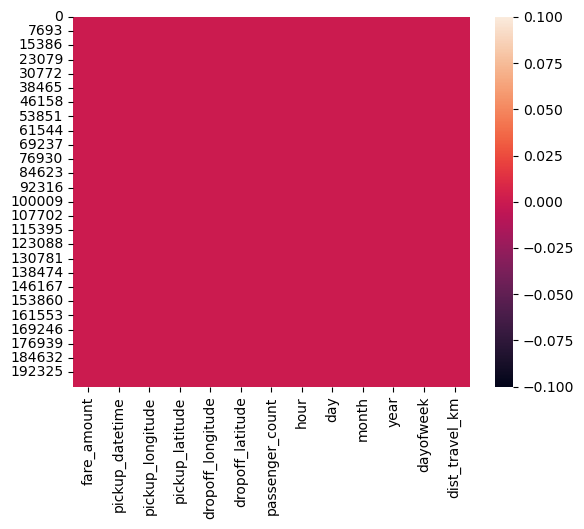

In [156]:
sns.heatmap(df.isnull()) #Free for null values

In [157]:
corr = df.corr() #Function to find the correlation
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
fare_amount,1.000000,0.003760,-0.002028,0.001691,-0.003668,0.013624,-0.023623,0.004534,0.030817,0.141277,0.013652,0.016683
pickup_longitude,0.003760,1.000000,-0.816461,0.833026,-0.846324,-0.000414,0.002433,0.005184,-0.004665,0.009966,0.000825,0.105581
pickup_latitude,-0.002028,-0.816461,1.000000,-0.774787,0.702367,-0.001560,-0.003822,-0.008264,0.004625,-0.010233,-0.002455,-0.062436
dropoff_longitude,0.001691,0.833026,-0.774787,1.000000,-0.917010,0.000034,0.003478,0.005056,-0.003606,0.008467,0.000002,0.056717
dropoff_latitude,-0.003668,-0.846324,0.702367,-0.917010,1.000000,-0.000659,-0.002544,-0.007835,0.003818,-0.011239,-0.002335,-0.079944
passenger_count,0.013624,-0.000414,-0.001560,0.000034,-0.000659,1.000000,0.013196,0.003252,0.009773,0.004798,0.033196,-0.001473
hour,-0.023623,0.002433,-0.003822,0.003478,-0.002544,0.013196,1.000000,0.004677,-0.003926,0.002156,-0.086947,-0.000640
day,0.004534,0.005184,-0.008264,0.005056,-0.007835,0.003252,0.004677,1.000000,-0.017360,-0.012170,0.005617,-0.002115
month,0.030817,-0.004665,0.004625,-0.003606,0.003818,0.009773,-0.003926,-0.017360,1.000000,-0.115859,-0.008786,-0.000633
year,0.141277,0.009966,-0.010233,0.008467,-0.011239,0.004798,0.002156,-0.012170,-0.115859,1.000000,0.006113,0.026378


<Axes: >

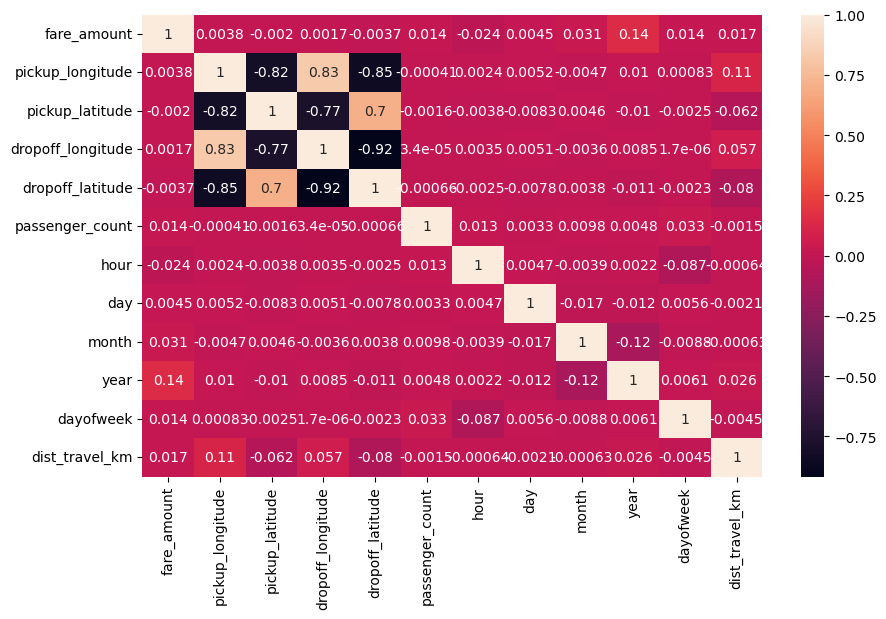

In [158]:
fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot = True) #Correlation Heatmap (Light values means highly correlated)

### Dividing the dataset into feature and target values

In [159]:
x = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month',
        'year','dayofweek','dist_travel_km']]

In [160]:
y = df['fare_amount']

### Dividing the dataset into training and testing dataset

In [161]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.33)

In [162]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()

### Linear Regression

In [163]:
regression.fit(X_train,y_train)

LinearRegression()

In [164]:
regression.intercept_ #To find the linear intercept

-863.8586819825009

In [165]:
regression.coef_ #To find the linear coeeficient

array([ 2.02576598e-03, -6.70690390e-03, -5.27278620e-03,  1.06491298e-03,
        4.90290922e-02, -1.72581765e-02,  5.87424424e-03,  7.95287778e-02,
        4.34148089e-01,  2.46256060e-02,  1.56765583e-04])

In [166]:
prediction = regression.predict(X_test) #To predict the target values
print(prediction)

[10.48765575  9.99408559  9.23822956 ...  9.48220877 11.35566485
 10.50627068]


In [167]:
y_test

153516    12.0
172012     6.5
110449     3.7
155824     5.3
67598      7.5
          ... 
128785    14.5
99002      4.1
33585      9.3
53027      7.5
43861      7.5
Name: fare_amount, Length: 66000, dtype: float64

### Metrics Evaluation using R2, Mean Squared Error, Root Mean Sqared Error

In [168]:
from sklearn.metrics import r2_score

In [169]:
r2_score(y_test,prediction)

0.02159207927055906

In [170]:
from sklearn.metrics import mean_squared_error

In [171]:
MSE = mean_squared_error(y_test,prediction)
MSE

29.22254510774845

In [172]:
RMSE = np.sqrt(MSE)
RMSE

5.40578811162151

### Random Forest Regression

In [173]:
from sklearn.ensemble import RandomForestRegressor

In [174]:
rf = RandomForestRegressor(n_estimators=100) #Here n_estimators means number of trees you want to build before making the prediction

In [175]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [176]:
y_pred = rf.predict(X_test)
y_pred

array([13.935,  4.562,  4.008, ...,  8.397,  8.   ,  7.688])

### Metrics evaluatin for Random Forest

In [177]:
R2_Random = r2_score(y_test,y_pred)
R2_Random

0.8176883409288362

In [178]:
MSE_Random = mean_squared_error(y_test,y_pred)
MSE_Random

5.445183514973592

In [179]:
RMSE_Random = np.sqrt(MSE_Random)
RMSE_Random

2.3334917002152786